# Retinanet Object Detection

## 设置数据集

请将数据集压缩包上传到Image文件夹下，上传完成后执行下面的代码解压文件。
确保解压后的Image目录下的结构如下：

|Image

|—VOCdevkit

|——-VOC2007(具体数据集文件夹名称)

|————Annotations

        └─  *.xml # 存放图片的类别与边框

|————JPEGImages

        └─ *.jpg # 存放图片

|————ImageSets

|——————Main

            └─ *.txt # 存放训练集、验证集所用图片名称，请确保包括了train.txt 和 val.txt，其中包含了图片的文件名，图片分别用于训练和验证，没有交集

### 解压数据集

### ❗ 下面的单元格需要修改 ❗

In [1]:
#unzip *.zip
import os
#工作目录转到Image文件夹下
os.chdir('/home/msft/msfthack/Image')
#下载测试用数据集
#!wget https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
#解压数据集
# 请将文件名修改为实际压缩文件名 zip文件使用unzip解压,tar文件用tar解压
#!unzip helmet.zip
#!tar xf helmet.tar
!ls

helmet.rar  helmet.zip	VOCdevkit  VOCtrainval_06-Nov-2007.tar


如果有图片扩展名为大写，取消下面单元格注释并执行

In [2]:
#import os
#os.chdir('/home/msft/msfthack/Image/VOCdevkit/helmet/JPEGImages/')
#!rename 'y/A-Z/a-z/' *

### 设置数据集参数

### ❗ 下面的单元格需要修改 ❗

In [4]:
#请修改文件夹名称
imagefolder = 'helmet'
#下面一行不需要修改
os.chdir('/home/msft/msfthack/Image/VOCdevkit/' + imagefolder)

## 标签格式转换
将VOC格式标签转换为CSV格式

❗请注意修改下面单元格中有❗的部分

### ❗ 下面的单元格需要修改 ❗

In [18]:
# -*- coding:utf-8 -*-

import csv
import os
import glob
import sys

classnames = []

class PascalVOC2CSV(object):
    def __init__(self,xml=[], ann_path='./annotations.csv',classes_path='./classes.csv'):
        '''
        :param xml: 所有Pascal VOC的xml文件路径组成的列表
        :param ann_path: ann_path
        :param classes_path: classes_path
        '''
        self.xml = xml
        self.ann_path = ann_path
        self.classes_path=classes_path
        self.label=[]
        self.annotations=[]

        self.data_transfer()
        self.write_file()


    def data_transfer(self):
        for num, xml_file in enumerate(self.xml):
            try:
                # print(xml_file)
                # 进度输出
                sys.stdout.write('\r>> Converting image %d/%d' % (
                    num + 1, len(self.xml)))
                sys.stdout.flush()

                with open(xml_file, 'r') as fp:
                    for p in fp:
                        if '<filename>' in p:
                            self.filen_ame = p.split('>')[1].split('<')[0]
                            if not self.filen_ame.endswith('.jpg'):
                                self.filen_ame = self.filen_ame + '.jpg'

                        if '<object>' in p:
                            # 类别
                            d = [next(fp).split('>')[1].split('<')[0] for _ in range(9)]
                            self.supercategory = d[0]
                            if self.supercategory not in self.label:
                                self.label.append(self.supercategory)
                                if self.supercategory not in classnames:
                                    classnames.append(self.supercategory)

                            # bbox
                            #❗❗ if you have truncated and difficult property, uncomment following 4 lines ❗❗
                            #❗❗如果你的xml属性中标注了truncated 和 difficult，请将下面4行取消注释 ❗❗
                            #x1 = int(d[-4]);
                            #y1 = int(d[-3]);
                            #x2 = int(d[-2]);
                            #y2 = int(d[-1])
                            #❗❗if you don't have truncated and difficult property, uncomment following 4 lines ❗❗
                            #❗❗如果你的xml 属性中没有标注truncated 和 difficult，请将下面4行取消注释❗❗
                            x1 = int(d[3])
                            y1 = int(d[4])
                            x2 = int(d[5])
                            y2 = int(d[6])

                            self.annotations.append([os.path.join('JPEGImages',self.filen_ame),x1,y1,x2,y2,self.supercategory])
            except:
                continue

        sys.stdout.write('\n')
        sys.stdout.flush()

    def write_file(self,):
        with open(self.ann_path, 'w', newline='') as fp:
            csv_writer = csv.writer(fp, dialect='excel')
            csv_writer.writerows(self.annotations)

        class_name=sorted(self.label)
        class_=[]
        for num,name in enumerate(classnames):
            class_.append([name,num])
        with open(self.classes_path, 'w', newline='') as fp:
            csv_writer = csv.writer(fp, dialect='excel')
            csv_writer.writerows(class_)

In [19]:
with open('ImageSets/Main/train.txt', 'r') as f:
    trainxml = ['Annotations/' + item[:-1] + '.xml' for item in f.readlines()]
with open('ImageSets/Main/val.txt', 'r') as f:
    valxml = ['Annotations/' + item[:-1] + '.xml' for item in f.readlines()]

PascalVOC2CSV(trainxml,ann_path='./annotations_train.csv')
PascalVOC2CSV(valxml,ann_path='./annotations_val.csv')
labels_to_names=dict(zip(range(len(classnames)),classnames))
print(labels_to_names)

>> Converting image 234/234
>> Converting image 16/16


如果有测试集对于的txt文件，请取消注释下面的命令

In [1]:
#with open('ImageSets/Main/test.txt', 'r') as f:
#    valxml = ['Annotations/' + item[:-1] + '.xml' for item in f.readlines()]

#PascalVOC2CSV(trainxml,ann_path='./annotations_test.csv')

查看生成的文件，应该有csv文件

In [8]:
!ls

Annotations	       classes.csv	 ImageSets   pascal_label_map.pbtxt
annotations_train.csv  helmet_train.txt  JPEGImages  weights
annotations_val.csv    helmet_val.txt	 labels


### 更新 keras至2.2.0版本

In [9]:
!python -m pip install --upgrade keras

Requirement already up-to-date: keras in /anaconda/envs/py35/lib/python3.5/site-packages
Requirement already up-to-date: h5py in /anaconda/envs/py35/lib/python3.5/site-packages (from keras)
Requirement already up-to-date: scipy>=0.14 in /anaconda/envs/py35/lib/python3.5/site-packages (from keras)
Requirement already up-to-date: numpy>=1.9.1 in /anaconda/envs/py35/lib/python3.5/site-packages (from keras)
Requirement already up-to-date: keras-preprocessing==1.0.1 in /anaconda/envs/py35/lib/python3.5/site-packages (from keras)
Requirement already up-to-date: six>=1.9.0 in /anaconda/envs/py35/lib/python3.5/site-packages (from keras)
Requirement already up-to-date: pyyaml in /anaconda/envs/py35/lib/python3.5/site-packages (from keras)
Requirement already up-to-date: keras-applications==1.0.2 in /anaconda/envs/py35/lib/python3.5/site-packages (from keras)
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' co

如果上面的命令更新不可用请尝试下面的命令

In [20]:
#!import sys
#!{sys.executable} -m pip install --upgrade keras

## 开始训练

### ❗ 下面的单元格需要修改 ❗

请根据数据集情况设置epoch和steps值，epoch为训练轮数，steps为每一轮训练使用的样本数

建议将steps设置为训练集大小

在训练集较小时可以将epoch设置为10或更大，训练集较大时需要更大的值

In [41]:
!retinanet-train --epoch=10 --steps=250 csv ./annotations_train.csv ./classes.csv --val-annotations=./annotations_val.csv

Using TensorFlow backend.
2018-07-17 17:53:56.802958: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2018-07-17 17:53:56.879358: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1212] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 2070:00:00.0
totalMemory: 11.17GiB freeMemory: 4.42GiB
2018-07-17 17:53:56.879405: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1312] Adding visible gpu devices: 0
2018-07-17 17:53:57.173935: I tensorflow/core/common_runtime/gpu/gpu_device.cc:993] Creating TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 4188 MB memory) -> physical GPU (device: 0, name: Tesla K80, pci bus id: 2070:00:00.0, compute capability: 3.7)
Creating model, this may take a second...
__________________________________________________________________________________________________
Layer (type)            

/anaconda/envs/py35/lib/python3.5/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
Epoch 1/10
2018-07-17 17:54:11.368947: W tensorflow/core/common_runtime/bfc_allocator.cc:219] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.07GiB. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2018-07-17 17:54:12.536277: W tensorflow/core/common_runtime/bfc_allocator.cc:219] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.07GiB. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2018-07-17 17:54:12.559265: W tensorflow/core/common_runtime/bfc_allocator.cc:219] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.07GiB. The caller indicates that this is not a failure, but m

## 测试

模型转换,训练产生的模型需要转换才能用于测试。

列出模型，模型尾数表示训练轮数，可依据训练产生的日志挑选最佳模型。

In [54]:
!ls snapshots -lh

total 4.3G
-rw-rw-r-- 1 msft msft 417M Jul 17 17:58 resnet50_csv_01.h5
-rw-rw-r-- 1 msft msft 417M Jul 17 18:01 resnet50_csv_02.h5
-rw-rw-r-- 1 msft msft 417M Jul 17 18:05 resnet50_csv_03.h5
-rw-rw-r-- 1 msft msft 417M Jul 17 18:08 resnet50_csv_04.h5
-rw-rw-r-- 1 msft msft 417M Jul 17 18:12 resnet50_csv_05.h5
-rw-rw-r-- 1 msft msft 417M Jul 17 18:16 resnet50_csv_06.h5
-rw-rw-r-- 1 msft msft 417M Jul 17 18:19 resnet50_csv_07.h5
-rw-rw-r-- 1 msft msft 417M Jul 17 18:23 resnet50_csv_08.h5
-rw-rw-r-- 1 msft msft 417M Jul 17 18:26 resnet50_csv_09.h5
-rw-rw-r-- 1 msft msft 417M Jul 17 18:30 resnet50_csv_10.h5
-rw-rw-r-- 1 msft msft 140M Jul 17 18:58 val_model.h5


### ❗ 下面的单元格需要修改 ❗

请将下面`resnet50_csv_10.h5`改为实际选择的模型文件

In [52]:
modelname = 'resnet50_csv_10.h5'

In [56]:
get_ipython().system('retinanet-convert-model snapshots/' + modelname + ' snapshots/val_model.h5')

Using TensorFlow backend.
2018-07-17 19:02:03.457706: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2018-07-17 19:02:03.529790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1212] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 2070:00:00.0
totalMemory: 11.17GiB freeMemory: 4.42GiB
2018-07-17 19:02:03.529837: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1312] Adding visible gpu devices: 0
2018-07-17 19:02:03.781163: I tensorflow/core/common_runtime/gpu/gpu_device.cc:993] Creating TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 4188 MB memory) -> physical GPU (device: 0, name: Tesla K80, pci bus id: 2070:00:00.0, compute capability: 3.7)


在测试集上验证模型

### ❗ 下面的单元格需要修改 ❗

请将`annotations_train.csv`改为实际测试集对于的文件

In [44]:
!retinanet-evaluate csv annotations_train.csv classes.csv snapshots/val_model.h5

Using TensorFlow backend.
2018-07-17 18:34:10.302973: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2018-07-17 18:34:10.375985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1212] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 2070:00:00.0
totalMemory: 11.17GiB freeMemory: 4.42GiB
2018-07-17 18:34:10.376030: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1312] Adding visible gpu devices: 0
2018-07-17 18:34:10.625529: I tensorflow/core/common_runtime/gpu/gpu_device.cc:993] Creating TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 4188 MB memory) -> physical GPU (device: 0, name: Tesla K80, pci bus id: 2070:00:00.0, compute capability: 3.7)
Loading model, this may take a second...
/anaconda/envs/py35/lib/python3.5/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in 

## 单张图片测试

In [25]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


In [45]:
model_path = 'snapshots/val_model.h5'

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
#model = models.load_model(model_path, backbone_name='resnet50', convert_model=True)

/anaconda/envs/py35/lib/python3.5/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### ❗ 下面的单元格需要修改 ❗

In [58]:
#只需要修改下面一行的图片名称
imagename = '483510.jpg'
#下一行不需要修改
imagepath = '/home/msft/msfthack/Image/VOCdevkit/' + imagefolder + '/JPEGImages/' + imagename

processing time:  0.39024806022644043


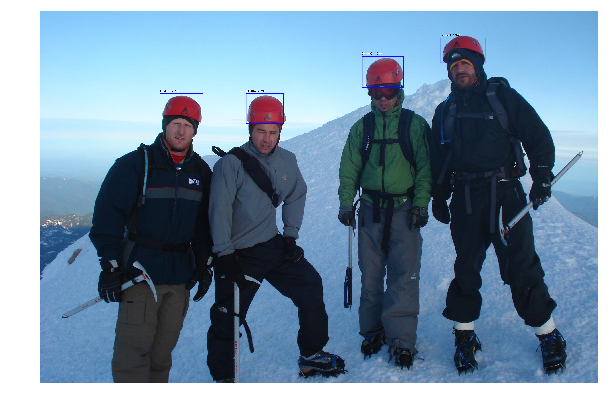

In [59]:
# load image
image = read_image_bgr(imagepath)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break

    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(draw)
plt.show()

## 训练可选参数

!retinanet-train --epoch=50 --steps=250 --batch-size=4 --backbone=resnet50 csv ./annotations.csv ./classes.csv --val-annotations=./annotations.csv

- epoch 表示训练轮数，通常在一定范围内增大训练轮数能够提高模型的准确率

- steps 表示一轮训练使用的样本数目，可设定为训练样本总数

- batch-size 每一个batch的大小，如果显存足够，可以适当增加这个值加快模型训练进程,默认为1

- backbone 选择网络结构，默认是resnet50,可选`resnet50`，`resnet101`，`resnet152`，`mobilenet128_1.0`，`mobilenet128_0.75`，`mobilenet160_1.0`等


### 移动模型文件到retinanetweights文件夹中供下载

在上面用到的模型将被复制到图片数据集目录下的retinanetweights文件夹中，请在Jupyter Notebook中浏览到相应目录下载

如果已经执行过一次下面的命令后需要继续转移新的模型，请注释下面的第一行并修改上面用到的modelname值，运行模型转换后的命令后再运行第二行命令

In [57]:
get_ipython().system('mkdir /home/msft/msfthack/Image/VOCdevkit/' + imagefolder + '/retinanetweights')
get_ipython().system('mv /home/msft/msfthack/Image/VOCdevkit/' + imagefolder + '/snapshots/val_model.h5' + ' /home/msft/msfthack/Image/VOCdevkit/' + imagefolder +'/retinanetweights/')